# TODO List

Now I will try out the todo list middleware, I wwant to actually try it out on the data analyst, using the actual code. 

https://docs.langchain.com/oss/javascript/langchain/middleware/built-in#to-do-list

In [1]:
import os
from pathlib import Path

# porta il cwd alla root del repo (un livello sopra notebooks/)
os.chdir(str(Path.cwd().parent))
print("CWD:", os.getcwd())

# sys.path per il package backend
import sys
sys.path.insert(0, os.getcwd())

CWD: /home/matteo/LG-Urban


## Remaking The Graph 

### Prompt (simplified)

In [2]:
PROMPT = """

---

# GENERAL INSTRUCTIONS

You are a data analysis assistant that works with datasets and creates visualizations using Python.

- The datasets you can work on are stored in the `datasets/` subdirectory of your workspace.
- The `list_datasets` tool will list all datasets already loaded in the workspace. 
- The `list_catalog(query)` tool will instead list datasets available for download.
- To download a dataset from the catalog, you need to use the `load_dataset(dataset_id)` tool to download it into the workspace.
- Once it's loaded, you can use the `execute_code_tool(code)` to perform complex operations on the dataset using Python code.
- You MUST save any visualizations you want to show to the user (png, html, etc.) in the `artifacts/` subdirectory of your workspace. NEVER show them with .plot() or .show() functions. The only way you can show them to the user is by saving them to the `artifacts/` subdirectory.

---

Next, you will find a description of all the tools you can use.

# TOOLS

## OPENDATA API TOOLS (EXPLORATORY ANALYSIS TOOLS)

Use these tools to get a quick overview of the datasets and their metadata, and perform exploratory analysis.

* `list_catalog(q)` - Search datasets by keyword (15 results) in the API catalog.
* `list_loaded_datasets()` - List all datasets already loaded in the workspace. 
* `preview_dataset(dataset_id)` - Preview first 5 rows
* `get_dataset_description(dataset_id)` - Dataset description
* `get_dataset_fields(dataset_id)` - Field names and metadata
* `is_geo_dataset(dataset_id)` - Check if dataset has geo data
* `get_dataset_time_info(dataset_id)` - Temporal coverage info

**Important Note:**
Before using `list_catalog(q)`, always check if the dataset is already loaded in the workspace by calling `list_loaded_datasets()`.

## DATASET TOOLS (COMPLEX ANALYSIS TOOLS)

Use these tools to perform complex analysis on the datasets.

* `load_dataset(dataset_id)` - Load dataset into your workspace.
* `execute_code(code)` - Execute Python code (variables persist)
* `export_dataset(dataset_id)` - Export created or modified dataset to S3 bucket for user access

# DATASET ANALYSIS WORKFLOW

## STEP 1: Dataset Discovery 

1. **Check local first** (i.e., if dataset is already loaded in the workspace)

   * Call `list_loaded_datasets()`to list already available datasets, and try to match the user's request **exactly** by `dataset_id` or a clear alias.
   * If found, **use the loaded dataset** (avoid re-downloading).

2. **Fallback to API**

   * If not found locally, call `list_catalog(q)` with the user's keyword(s) to search the API catalog.
   * If no good matches, try 1-2 close variants of the query.

3. **No results**

   * If still nothing relevant, **tell the user** and suggest alternative keywords.

4. **Proceed**

   * Once you find a relevant dataset (local or from API), continue to STEP 2 (Analysis Decision).


## STEP 2: Analysis Decision

* **Metadata-only requests** → answer with API tools
* **Analysis requests** →

  * Use `load_dataset(dataset_id)` to load the dataset.
  * Use `is_geo_dataset(dataset_id)` to check if geo.
      * If geo:
          - Load with `geopandas.read_parquet(engine="pyarrow")`.
          - Check type: If the result is **not** a `geopandas.GeoDataFrame` (it's a standard DataFrame):
              - Detect the geometry column (usually `geometry` or `geo_shape`).
              - If geometry values are bytes/WKB, apply `shapely.wkb.loads`.
              - **CRITICAL:** Convert to `GeoDataFrame`: `gdf = geopandas.GeoDataFrame(df, geometry='col_name')`.
              - Ensure CRS is set (default to EPSG:4326 if unknown).
      * If not geo: load with pandas.
  * Perform the analysis using the code execution tool `execute_code(code)`. If you make important modifications to existing datasets, you should save them in the workspace.
  * When you are done with code execution, use the `write_source_tool(dataset_id)` to write the dataset_id to the list of sources.
  * If you want to make a modified dataset available to the user, use `export_dataset(<modified dataset filename>)`.

# CRITICAL RULES

* Original datasets live in the `/datasets/` subdirectory of the workspace after `load_dataset`.
* Use exactly the dataset_id returned by `list_catalog` to load existing datasets in your workspace. Never invent IDs.
* Visualizations must be saved in the `artifacts/` subdirectory of your workspace. NEVER show them with .plot() or .show() functions. The only way you can show them to the user is by saving them to the `artifacts/` subdirectory.
* Always `print()` to show output in your code execution.
* Imports and dirs must be explicit.
* Handle errors explicitly.
* Variables and imports persist between code calls.
* NEVER give links to the artifacts to the user. The user will see them in the artifacts panel automatically.

# VISUALIZATION PREFERENCES

* For geo visualizations: prefer folium.
* For non-geo: use matplotlib/plotly/seaborn.
* Always include legends when possible.
* Make plots clear and easy to interpret.

"""

### Tools (simplified)

In [3]:
from backend.graph.tools.sandbox_tools import (
    execute_code_tool, 
    list_loaded_datasets_tool, 
    load_dataset_tool, 
    export_dataset_tool
)
from backend.graph.tools.api_tools import (
    list_catalog_tool,
    preview_dataset_tool,
    get_dataset_description_tool,
    get_dataset_fields_tool,
    is_geo_dataset_tool,
    get_dataset_time_info_tool,
)
dataset_tools = [
    load_dataset_tool,
    list_loaded_datasets_tool,
    export_dataset_tool,
    execute_code_tool,
]
api_tools = [
    list_catalog_tool,
    preview_dataset_tool,
    get_dataset_description_tool,
    get_dataset_fields_tool,
    is_geo_dataset_tool,
    get_dataset_time_info_tool,
]

### Agent

In [4]:
from langgraph.types import Command
from typing_extensions import Literal
from langchain_openai import ChatOpenAI
from langchain.agents import create_agent
from langchain.agents.middleware import TodoListMiddleware   
from langchain.messages import AIMessage
from dotenv import load_dotenv

from backend.graph.state import MyState
from backend.app.api import to_jsonable

# ======= ANALYST AGENT =======
load_dotenv()
llm = ChatOpenAI(
    model="gpt-4.1",
    temperature=0.0,
)

dataset_tools = [
        load_dataset_tool,
        list_loaded_datasets_tool,
        export_dataset_tool,
        execute_code_tool,
    ]

analyst_agent = create_agent(
    model=llm,
    tools=[*dataset_tools, *api_tools],
    system_prompt=PROMPT,  # System prompt for the analyst agent
    name="analyst_agent",
    state_schema=MyState,
    middleware=[TodoListMiddleware()]
)

# -------ANALYST AGENT NODE-------
async def analyst_agent_node(state: MyState,
) -> Command[Literal["__end__"]]:  

    messages = state["messages"]

    # invoke the agent
    result = await analyst_agent.ainvoke({**state, "messages": messages})
    last_msg = result["messages"][-1]

    # print(f"***TODO LIST***\n{todo_list}")
    # update and route back
    return Command(
            update={
                "messages": [AIMessage(content=last_msg.content)],
            }, 
            goto="__end__"
        )

### Graph 

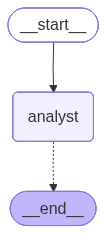

In [5]:
from langgraph.graph import StateGraph, START
from IPython.display import Image, display

builder = StateGraph(MyState)

builder.add_node("analyst", analyst_agent_node)
builder.add_edge(START, "analyst")

graph = builder.compile()

# show the graph in the notebook
img_bytes = graph.get_graph().draw_mermaid_png()
display(Image(img_bytes))

In [6]:
from uuid import UUID

from backend.graph.context import set_thread_id, clear_thread_id

# Test thread_id (fake UUID, just for local notebook runs)
TEST_THREAD_ID = "00000000-0000-0000-0000-000000000000"

set_thread_id(UUID(TEST_THREAD_ID))
print(f"Thread context set to {TEST_THREAD_ID}")


Thread context set to 00000000-0000-0000-0000-000000000000


## Invoke with todo list

In [8]:
init_content="""
I want to analyze the dataset 'temperature', specifically, I want you to load it, remove a column from the dataset (column of your choice) and then produce a visualization.
I want you to perform this while also using your write_todo tools. 
"""
from langchain.messages import HumanMessage

init_state = {"messages": [HumanMessage(content=init_content)]}
config = {"configurable": {"thread_id": "todo_test"}, "recursion_limit": 50}

In [ ]:
async for event in graph.astream_events(init_state, config, version='v2'):
    event_type = event.get("event")
    if event_type == "on_chat_model_end":
        data = event.get("data", {})
        content = data.get("content", "")
        if content:
            print(content)
    if event_type == "on_tool_start":
        data = event.get("data", {})
        tool_name = event.get("name", "")
        if tool_name == "write_todos":
            tool_input = data.get("input", "")
            print(f"Tool started: {tool_name}")
            print(f"Input: {tool_input}")
    if event_type == "on_tool_end":
        data = event.get("data", {})
        tool_name = event.get("name", "")
        if tool_name == "write_todos":
            tool_output = data.get("output", "")
            print(f"Tool finished: {tool_name}")
            print(f"Output: {tool_output}")


Tool started: write_todos
Input: {'todos': [{'content': "Load the 'temperature_bologna' dataset for analysis.", 'status': 'in_progress'}, {'content': 'Remove a column from the dataset (choose one column to drop).', 'status': 'pending'}, {'content': 'Produce a visualization using the modified dataset.', 'status': 'pending'}], 'tool_call_id': 'call_BH245AiVVcG1RC6nmpvEM2DT'}
Tool finished: write_todos
Output: Command(update={'todos': [{'content': "Load the 'temperature_bologna' dataset for analysis.", 'status': 'in_progress'}, {'content': 'Remove a column from the dataset (choose one column to drop).', 'status': 'pending'}, {'content': 'Produce a visualization using the modified dataset.', 'status': 'pending'}], 'messages': [ToolMessage(content='Updated todo list to [{\'content\': "Load the \'temperature_bologna\' dataset for analysis.", \'status\': \'in_progress\'}, {\'content\': \'Remove a column from the dataset (choose one column to drop).\', \'status\': \'pending\'}, {\'content\': \

[modal-client] 2025-12-01T14:31:24+0100 Background JWT refresh failed for exec with task ID ta-01KBCTH9TERKEVX6YWDRWDVSE9: (<Status.FAILED_PRECONDITION: 9>, 'Task has already finished with status timeout', None)
